C:\Users\burak bozoğlu\AppData\Local\Temp\ipykernel_22408\971226608.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Disease Index'] = filtered_data.apply(calculate_disease_index, axis=1)
D:\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regular

Model Loss: 8.576588879805058e-05
Mean Absolute Error (MAE): 0.007641919422894716
Mean Squared Error (MSE): 8.576588879805058e-05


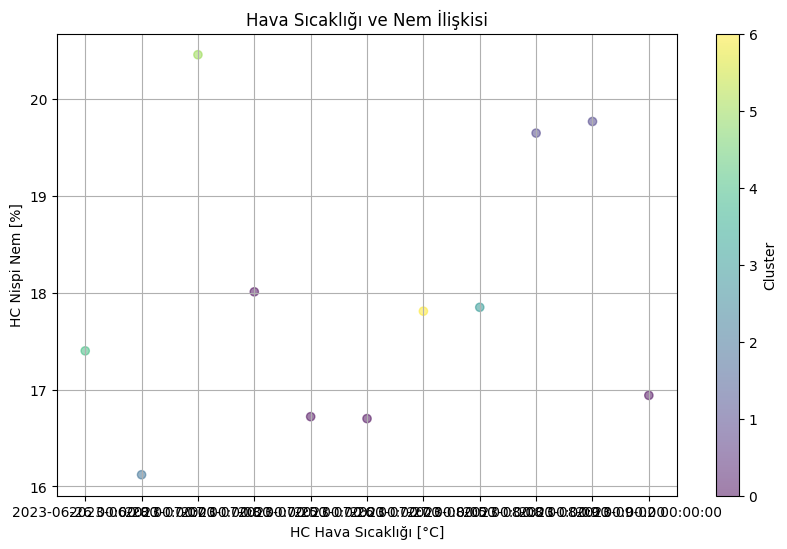

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Veri setini yükle
data = pd.read_csv("station_data1.csv")

# Gerekli öznitelikler
features = ['HC Hava Sıcaklığı [°C]', 'Dew Point [°C]', 'VPD [kPa]', 'HC Nispi Nem [%]', 'Yağış [mm]', 'Yaprak Islaklığı [min]', 'Solar Pnel [mV]', 'Batarya [mV]']

# Külleme hastalığı için filtreleme (örnek olarak sıcaklık ve nispi nem aralığı)
filtered_data = data[(data['HC Hava Sıcaklığı [°C]'].astype(float).between(25, 35)) &
                     (data['HC Nispi Nem [%]'].astype(float).between(32, 37))]

# Hastalık İndeksi hesaplama fonksiyonu
def calculate_disease_index(row):
    humidity = float(row['HC Nispi Nem [%]'])
    temperature = float(row['HC Hava Sıcaklığı [°C]'])
    leaf_wetness = float(row['Yaprak Islaklığı [min]'])
    if leaf_wetness == 0:
        return 0  # sıfıra bölme hatasını önlemek için
    disease_index = (humidity * temperature) / leaf_wetness
    return disease_index

# Hastalık İndeksi sütunu oluştur
filtered_data['Disease Index'] = filtered_data.apply(calculate_disease_index, axis=1)

# Küme sayısı
num_clusters = 7

# Giriş verilerini ayır
X = filtered_data[features].values
y = filtered_data['Disease Index'].values

# Verileri normalize et
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans ile kümeleme yap
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Derin öğrenme modeli oluştur
model = Sequential([
    Dense(64, activation='relu', input_shape=(len(features),)),
    Dense(32, activation='relu'),
    Dense(1)  # Hastalık İndeksi için tek bir çıkış
])

# Modeli derle
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Modeli eğit
model.fit(X_scaled, y, epochs=50, verbose=0)

# Modelin performansını değerlendirme
loss, mae, mse = model.evaluate(X_scaled, y, verbose=0)
print("Model Loss:", loss)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

# Scatter plot çizimi için özniteliklerin indislerini alın
temp_index = features.index('HC Hava Sıcaklığı [°C]')
humid_index = features.index('HC Nispi Nem [%]')

# Veri setinden sıcaklık ve nem değerlerini alın
temperatures = filtered_data.iloc[:, temp_index]
humidities = filtered_data.iloc[:, humid_index]

# Scatter plot çizimi
plt.figure(figsize=(10, 6))
plt.scatter(temperatures, humidities, c=clusters, cmap='viridis', alpha=0.5)  # Kümelere göre renklendir
plt.colorbar(label='Cluster')
plt.title('Hava Sıcaklığı ve Nem İlişkisi')
plt.xlabel('HC Hava Sıcaklığı [°C]')
plt.ylabel('HC Nispi Nem [%]')
plt.grid(True)
plt.show()


